In [0]:
# Imports here
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
from torchvision import transforms, models, datasets
import matplotlib.pyplot as plt
from PIL import Image
import random 
import os
from PIL import ImageFilter
import json

In [4]:
!wget -nc https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!unzip -qq flower_data.zip

--2019-01-06 21:47:14--  https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.160.205
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.160.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 311442766 (297M) [application/zip]
Saving to: ‘flower_data.zip’

flower_data.zip     100%[===================>] 297.01M  36.0MB/s    in 9.1s    

2019-01-06 21:47:24 (32.5 MB/s) - ‘flower_data.zip’ saved [311442766/311442766]



In [0]:
def augment_img(path, limit):
    files= [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    initial_count= len(files)
    offset= limit-initial_count
    filters= ['gaussian', 'mode', 'median', 'max', 'min']
    for i in range(offset):
        img= Image.open(os.path.join(path, files[i%initial_count]))
        transform= random.choice(filters)
        if transform== 'gaussian':
            new_img= img.filter(ImageFilter.GaussianBlur(radius=3))
        elif transform== 'mode':
            new_img= img.filter(ImageFilter.ModeFilter(size=9))
        elif transform== 'median':
            new_img= img.filter(ImageFilter.MedianFilter(size=9))
        elif transform=='max':
            new_img= img.filter(ImageFilter.MaxFilter(size=9))
        else:
            new_img= img.filter(ImageFilter.MinFilter(size=9))
        new_img.save(os.path.join(path, 'timg_%d.jpg' %i))
    print('finished augmenting directory %s' % path)

In [0]:
def balance_data(root, limit):
    directories= [f for f in os.listdir(root) if os.path.isdir(os.path.join(root, f))]
    for d in directories:
        augment_img(os.path.join(root, d),limit)
balance_data('flower_data/train', 206)

finished augmenting directory flower_data/train/71
finished augmenting directory flower_data/train/76
finished augmenting directory flower_data/train/36
finished augmenting directory flower_data/train/77
finished augmenting directory flower_data/train/19
finished augmenting directory flower_data/train/48
finished augmenting directory flower_data/train/42
finished augmenting directory flower_data/train/22
finished augmenting directory flower_data/train/8
finished augmenting directory flower_data/train/62
finished augmenting directory flower_data/train/66
finished augmenting directory flower_data/train/78
finished augmenting directory flower_data/train/79
finished augmenting directory flower_data/train/97
finished augmenting directory flower_data/train/11
finished augmenting directory flower_data/train/21
finished augmenting directory flower_data/train/18
finished augmenting directory flower_data/train/5
finished augmenting directory flower_data/train/38
finished augmenting directory flo

In [0]:
data_dir = './flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [0]:
# TODO: Define your transforms for the training and validation sets
train_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.RandomRotation(30),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# TODO: Load the datasets with ImageFolder
train_dataset = datasets.ImageFolder(root=train_dir, transform= train_transforms)
test_dataset= datasets.ImageFolder(root=valid_dir, transform= test_transforms)

valid_size = 0.2
batch_size= 32
num_test = len(test_dataset)
indices = list(range(num_test))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_test))
valid_idx, test_idx = indices[split:], indices[:split]

test_sampler = SubsetRandomSampler(test_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# TODO: Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
    sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, sampler=test_sampler)

In [0]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [0]:
#pretrained model
vgg16= models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:43<00:00, 12745478.71it/s]


In [0]:
#freeze param
for param in vgg16.features.parameters():
    param.requires_grad= False

In [0]:
vgg16.classifier= nn.Sequential(nn.Linear(vgg16.classifier[0].in_features, 4096, bias=True),
                                nn.ReLU(inplace=True),
                                nn.Dropout(0.6),
                                nn.Linear(4096, 4096, bias=True),
                                nn.ReLU(inplace=True),
                                nn.Dropout(0.6),
                                nn.Linear(4096, 102, bias=True),
                                nn.LogSoftmax(dim=1))

In [0]:

criterion= nn.NLLLoss().cuda()
optimizer= optim.SGD(vgg16.classifier.parameters(), lr=0.001, momentum=0.9, weight_decay= 0.0005, nesterov=True)
scheduler= lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

In [0]:
def save_model(model, name, dataset, optimizer, hidden_units, out_file):
  class_to_idx= dataset.class_to_idx
  checkpoint = {'arch': name,
                'hidden_units': hidden_units,
                'class_to_idx': class_to_idx,
                'state_dict': model.state_dict(),
                 'opt_dict': optimizer.state_dict()}

  torch.save(checkpoint, out_file)
  print('Checkpoint file saved!')

In [11]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
if train_on_gpu:
    vgg16.cuda()

In [23]:
#training step
n_epoch= 60
min_loss= np.inf
for epoch in range(1, n_epoch+1):
    train_loss= 0.0
    valid_loss= 0.0
    vgg16.train()
    for img, label in train_loader:
        if train_on_gpu:
            img, label = img.cuda(), label.cuda()
        optimizer.zero_grad()
        output= vgg16(img)
        loss= criterion(output, label)
        loss.backward()
        optimizer.step()
        train_loss+= loss.item() * img.size(0)
        
    vgg16.eval()
    correct=0
    with torch.no_grad():
      for img, label in valid_loader:
          if train_on_gpu:
              img, label = img.cuda(), label.cuda()
          output= vgg16(img)
          loss= criterion(output, label)
          valid_loss+= loss.item() * img.size(0)
          prob = torch.exp(output)
          top_prob, top_class = prob.topk(1, dim=1)
          equals = top_class == label.view(*top_class.shape)
          correct += torch.mean(equals.type(torch.FloatTensor))
    scheduler.step(valid_loss)


    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    if valid_loss < min_loss:
      min_loss= valid_loss
      save_model(vgg16, 'vgg16', train_dataset, optimizer, 4096, 'vgg16.pth')
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch, train_loss, valid_loss, correct/len(valid_loader)))

Checkpoint file saved!
Epoch: 1 	Training Loss: 0.335387 	Validation Loss: 0.343833 	Validation Accuracy: 0.895437
Epoch: 2 	Training Loss: 0.333255 	Validation Loss: 0.343982 	Validation Accuracy: 0.895437
Checkpoint file saved!
Epoch: 3 	Training Loss: 0.336322 	Validation Loss: 0.343587 	Validation Accuracy: 0.893750
Epoch: 4 	Training Loss: 0.336936 	Validation Loss: 0.343885 	Validation Accuracy: 0.895437
Checkpoint file saved!
Epoch: 5 	Training Loss: 0.333599 	Validation Loss: 0.343464 	Validation Accuracy: 0.898611
Checkpoint file saved!
Epoch: 6 	Training Loss: 0.327754 	Validation Loss: 0.343262 	Validation Accuracy: 0.900099
Epoch: 7 	Training Loss: 0.335417 	Validation Loss: 0.343320 	Validation Accuracy: 0.899901
Epoch: 8 	Training Loss: 0.329667 	Validation Loss: 0.343408 	Validation Accuracy: 0.898611
Checkpoint file saved!
Epoch: 9 	Training Loss: 0.325985 	Validation Loss: 0.343059 	Validation Accuracy: 0.903274
Checkpoint file saved!
Epoch: 10 	Training Loss: 0.332547

In [0]:
#load checkpoint
def load_checkpoint(filename):
    checkpoint= torch.load(filename)
    model= models.vgg16(pretrained=True)
    for param in model.features.parameters():
        param.requires_grad= False
    classifier= nn.Sequential(nn.Linear(25088, 4096),
                            nn.ReLU(),
                            nn.Dropout(0.5),
                            nn.Linear(4096, 4096),
                            nn.ReLU(),
                            nn.Dropout(0.5),
                            nn.Linear(4096, 102),
                            nn.LogSoftmax(dim=1))
    model.classifier= classifier
    model.load_state_dict(checkpoint['state_dict'])
    return model

In [25]:
# Test accuracy
correct=0
with torch.no_grad():
  for inputs, labels in test_loader:
      if train_on_gpu:
          inputs, labels = inputs.cuda(), labels.cuda()
      # obtain the outputs from the model
      outputs = model_200(inputs)
      # max provides the (maximum probability, max value)
      _, predicted = outputs.max(dim=1)
      equals = predicted == labels.data
      correct += equals.float().mean()
  print(correct/len(test_loader))

tensor(0.8958, device='cuda:0')


In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    img= Image.open(image)
    img= img.resize(size=(256, 256))
    center= 255//2
    offset= 224//2
    img= img.crop((center-offset, center-offset, center+offset, center+offset ))
    np_img= np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_img = (np_img - mean)/std    
    np_img = np.transpose(np_img, (2, 0, 1))
    return np_img
    

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

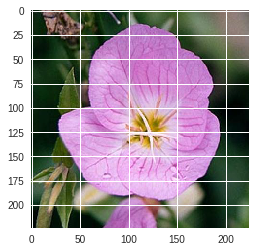

In [32]:
%matplotlib inline

fldata= process_image('sample.jpg')
fl= imshow(fldata)

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.cpu()
    idx_to_class = {val: key for key, val in train_dataset.class_to_idx.items()}
    img= process_image(image_path)
    img = torch.from_numpy(img).type(torch.FloatTensor)
    img= img.reshape((1, 3, 224, 224))
    log_val = model(img) 
    prob_dist = torch.exp(log_val) 
    top_prob, top_class = prob_dist.topk(topk)
    top_prob= top_prob.detach().numpy()[0]
    top_class= top_class.detach().numpy()[0]
    top_fl = [idx_to_class[clss] for clss in top_class]
    return top_prob, top_fl
    

In [36]:
model.cpu()
predict('sample.jpg', model)

(array([0.47708854, 0.23310319, 0.20634119, 0.03253264, 0.01753776],
       dtype=float32), ['1', '19', '97', '55', '51'])

In [0]:
# TODO: Display an image along with the top 5 classes
def showTopFive(image_path, model, mapping):
    model.cpu()
    imshow(process_image(image_path))
    prob, flower= predict(image_path, model)
    flower_name= [mapping[f] for f in flower]
    fig, ax = plt.subplots()
    y_offset = np.arange(5)
    ax.barh(y_offset, prob, align='center',
            color='blue', ecolor='black')
    ax.set_yticks(y_offset)
    ax.set_yticklabels(flower_name)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Probability')
    ax.set_title('Top 5 Classes ')
    plt.show()

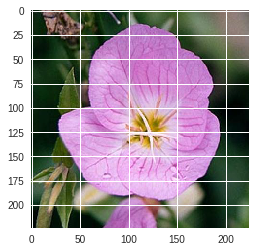

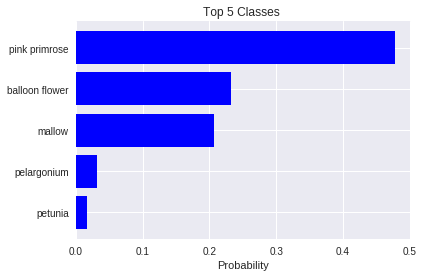

In [37]:
showTopFive('sample.jpg', model, cat_to_name)